In [3]:
!pip install openeo
!pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.8/315.8 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 206.8/206.8 kB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 41.4 MB/s eta 0:00:00
  Attempting uninstall: xarray
    Found existing installation: xarray 2025.7.1
    Uninstalling xarray-2025.7.1:
      Successfully uninstalled xarray-2025.7.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 85.2 MB/s eta 0:00:00


In [4]:
import warnings
warnings.filterwarnings("ignore")

import logging
logging.getLogger('rasterio').setLevel(logging.ERROR)


# Lago de Amatitlán

Primero realizamos las importaciones necesarias.

In [5]:

import rasterio
import numpy as np
import matplotlib.pyplot as plt
from datetime import date
import openeo

Seguidamente se debe establecer conexión con el sitio de Copernicus, para lo cual se necestiaba tener una cuenta registrada.

In [6]:
connection = openeo.connect("https://openeo.dataspace.copernicus.eu").authenticate_oidc()

Visit https://identity.dataspace.copernicus.eu/auth/realms/CDSE/device?user_code=PWIM-PXRU 📋 to authenticate.

✅ Authorized successfully

Authenticated using device code flow.


Se deben proveer las coordenadas del área que se desea estudiar. En este caso Lago de Amatitlán.

In [9]:
import json

with open("/Lago_Amatitlan.geojson") as f:
    fc = json.load(f)

coords = fc["features"][0]["geometry"]["coordinates"][0]


lons, lats = zip(*coords)
spatial_extent = {
    "west": min(lons),
    "south": min(lats),
    "east": max(lons),
    "north": max(lats)
}


Establecemos los rangos de fecha sobre los cuales queremos trabajar. El PDF menciona 6, pero se permitieron colo 3 por cuestiones de tiempo y recursos.

In [10]:
periodos = {
    "mayo":   ("2025-05-01", "2025-05-31"),
    "junio":  ("2025-06-01", "2025-06-30"),
    "julio":  ("2025-07-01", "2025-07-31"),
}


Descargamos los archivos con las configuraciones en el chunk.

In [11]:
for mes, (fecha_inicio, fecha_fin) in periodos.items():

    cube = (
        connection
        .load_collection(
            "SENTINEL2_L2A",
            spatial_extent=spatial_extent,
            temporal_extent=[fecha_inicio, fecha_fin]
        )
        .filter_bands(["B04", "B08"])
    )

    salida = f"amatitlan_{mes}_2025.tif"
    cube.download(salida)
    print("Descargado:", salida)


Descargado: amatitlan_mayo_2025.tif
Descargado: amatitlan_junio_2025.tif
Descargado: amatitlan_julio_2025.tif


Hacemos una visualización para cada banda del mes de mayo 2025.

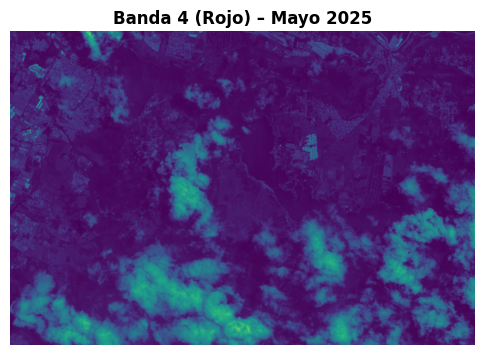

In [13]:
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt

with rasterio.open("amatitlan_mayo_2025.tif") as src:
    fig, ax = plt.subplots(figsize=(6, 6))
    show(src.read(1), ax=ax, title="Banda 4 (Rojo) – Mayo 2025")
    plt.axis("off")
    plt.show()


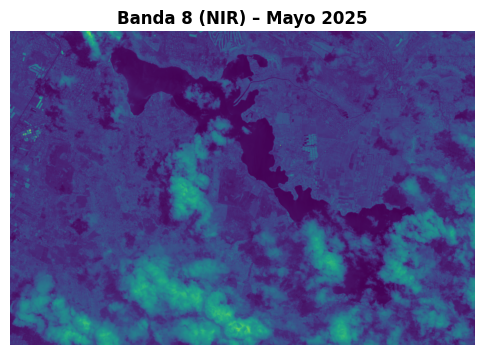

In [14]:
with rasterio.open("amatitlan_mayo_2025.tif") as src:
    fig, ax = plt.subplots(figsize=(6, 6))
    show(src.read(2), ax=ax, title="Banda 8 (NIR) – Mayo 2025")
    plt.axis("off")
    plt.show()


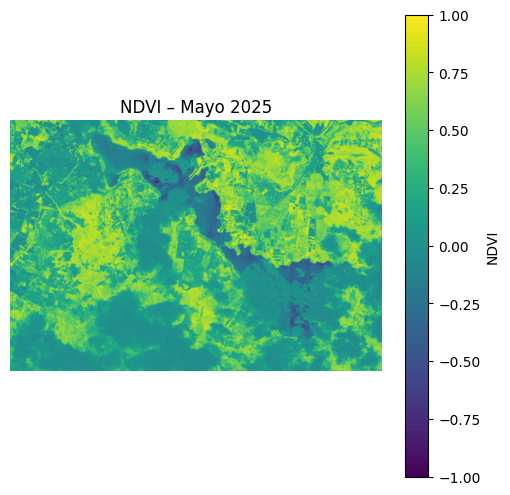

In [15]:
#mayo 2025
with rasterio.open("amatitlan_mayo_2025.tif") as src:
    red = src.read(1).astype("float32")
    nir = src.read(2).astype("float32")
    ndvi = (nir - red) / (nir + red + 1e-8)

    fig, ax = plt.subplots(figsize=(6, 6))
    im = ax.imshow(ndvi, vmin=-1, vmax=1)
    ax.set_title("NDVI – Mayo 2025")
    ax.axis("off")
    fig.colorbar(im, ax=ax, label="NDVI")
    plt.show()


Necesitamos más Bandas para hacer el estudio correspondiente de la cianobacteria, así que procedemos a descargarlos. Además, usamos fechas específicas provista por Lynette.

In [22]:
from datetime import datetime, timedelta
fechas_cyano = [
    "2025-02-07", "2025-02-10", "2025-02-25", "2025-02-27",
    "2025-03-02", "2025-03-04", "2025-03-07", "2025-03-09",
    "2025-03-12", "2025-03-14", "2025-03-19", "2025-03-22",
    "2025-03-24", "2025-03-26", "2025-04-03", "2025-04-11",
    "2025-04-13", "2025-04-15", "2025-04-16", "2025-04-18",
    "2025-04-28", "2025-05-03", "2025-05-13", "2025-05-28",
    "2025-07-10", "2025-07-17", "2025-07-20", "2025-07-24",
    "2025-08-01"
]
def rango_dias(fecha_str, delta=1):
    fecha = datetime.strptime(fecha_str, "%Y-%m-%d")
    inicio = (fecha - timedelta(days=delta)).strftime("%Y-%m-%d")
    fin = (fecha + timedelta(days=delta)).strftime("%Y-%m-%d")
    return inicio, fin


In [23]:
# Bandas necesarias
bandas = ["B02","B03","B04","B05","B07","B08","B8A","B11","B12"]

for i, fecha in enumerate(fechas_cyano, start=1):
    inicio, fin = rango_dias(fecha, delta=3)
    cube = (
        connection
        .load_collection(
            "SENTINEL2_L2A",
            spatial_extent=spatial_extent,
            temporal_extent=[inicio, fin]
        )
        .filter_bands(bandas)
    )
    salida = f"amatitlan_fecha_{i}_full.tif"
    cube.download(salida)
    print(f"Descargado: {salida}")


Descargado: amatitlan_fecha_1_full.tif
Descargado: amatitlan_fecha_2_full.tif
Descargado: amatitlan_fecha_3_full.tif
Descargado: amatitlan_fecha_4_full.tif
Descargado: amatitlan_fecha_5_full.tif
Descargado: amatitlan_fecha_6_full.tif
Descargado: amatitlan_fecha_7_full.tif
Descargado: amatitlan_fecha_8_full.tif
Descargado: amatitlan_fecha_9_full.tif
Descargado: amatitlan_fecha_10_full.tif
Descargado: amatitlan_fecha_11_full.tif
Descargado: amatitlan_fecha_12_full.tif
Descargado: amatitlan_fecha_13_full.tif
Descargado: amatitlan_fecha_14_full.tif
Descargado: amatitlan_fecha_15_full.tif
Descargado: amatitlan_fecha_16_full.tif
Descargado: amatitlan_fecha_17_full.tif
Descargado: amatitlan_fecha_18_full.tif
Descargado: amatitlan_fecha_19_full.tif
Descargado: amatitlan_fecha_20_full.tif
Descargado: amatitlan_fecha_21_full.tif
Descargado: amatitlan_fecha_22_full.tif
Descargado: amatitlan_fecha_23_full.tif
Descargado: amatitlan_fecha_24_full.tif
Descargado: amatitlan_fecha_25_full.tif
Descargad

Ahora tomamos una imagen satelital del lago y la recortamos para quedarnos con el áreade interés. Se limpian los valores sin información, se ajusta la escala de las bandas y se hacen cálculos para estimar la concentración de clorofila-a en la superficie del agua. A partir de esto se genera un mapa que muestra la distribución espacial de la clorofila-a dentro del lago.

La medición de clorofila-a se utiliza como un indicador indirecto de la presencia y proliferación de cianobacterias. Este pigmento está presente en todos los organismos fotosintéticos, incluidas las cianobacterias, y su concentración aumenta significativamente durante los eventos de floración. Por ello, identificar áreas y fechas con altos niveles de clorofila-a permite detectar y monitorear posibles episodios de crecimiento masivo de cianobacterias en el lago.


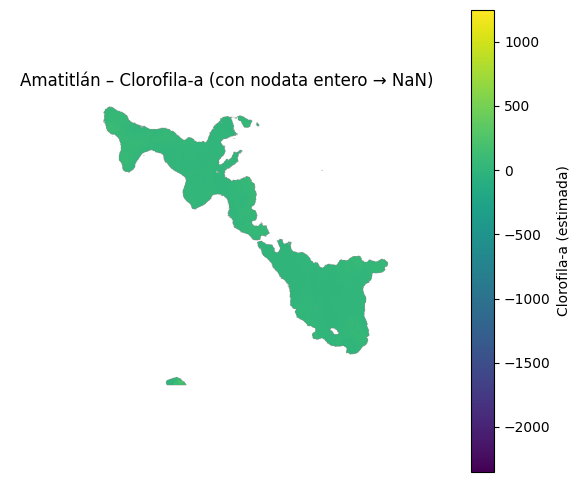

In [24]:
import numpy as np
import rasterio
from rasterio.mask import mask
from rasterio.warp import transform_geom
import matplotlib.pyplot as plt

ruta = "amatitlan_fecha_1_full.tif"

with rasterio.open(ruta) as src:
    geom_wgs84 = fc["features"][0]["geometry"]
    geom_raster = transform_geom("EPSG:4326", src.crs.to_string(), geom_wgs84, precision=6)

    band_dtype = np.dtype(src.dtypes[0])
    int_nodata = src.nodata if (src.nodata is not None and np.issubdtype(band_dtype, np.integer)) else -32768

    data, out_transform = mask(
        src,
        [geom_raster],
        crop=True,
        filled=True,
        nodata=int_nodata,
        indexes=list(range(1, 10))
    )

data = data.astype("float32")
data[data == float(int_nodata)] = np.nan

B02, B03, B04, B05, B07, B08, B8A, B11, B12 = data

if np.nanmedian(B04) > 1.5:
    for arr in (B02, B03, B04, B05, B07, B08, B8A, B11, B12):
        arr /= 10000.0

def safe_div(a, b):
    out = np.full_like(a, np.nan, dtype="float32")
    m = (b != 0) & np.isfinite(a) & np.isfinite(b)
    out[m] = a[m] / b[m]
    return out


MNDWI = safe_div((B03 - B11), (B03 + B11 + 1e-8))
NDWI  = safe_div((B03 - B08), (B03 + B08 + 1e-8))
water = (MNDWI > 0.42) | (NDWI > 0.40)


FAI  = B8A - B04 - (B07 - B04) * ((783 - 665) / (865 - 665))
NDCI = safe_div((B05 - B04), (B05 + B04 + 1e-8))
chl  = 826.57 * NDCI**3 - 176.43 * NDCI**2 + 19 * NDCI + 4.071

chl_masked = np.where(water & (FAI <= 0.08), chl, np.nan)

plt.figure(figsize=(7,6))
im = plt.imshow(chl_masked, cmap="viridis")
plt.colorbar(im, label="Clorofila-a (estimada)")
plt.title("Amatitlán – Clorofila-a (con nodata entero → NaN)")
plt.axis("off")
plt.show()


El mapa muestra como si bien fue posible aislar el contorno del lago, los valores de clorofila-a calculados incluyen cifras negativas y muy altas, lo que indica que el cálculo aún contiene ruido. Por lo que antes de poder interpretar el mapa como indicador de floraciones de cianobacterias se debe aplicar filtros para qudedarse únicamente con concentraciones realistas.


A continuación corregimos el cálculo anterior filtrando el índice NDCI a un rango válido, calculando la clorofila-a y eliminando valores fuera de un rango físico razonable (0 a 500 µg/L). Después aplicamos una máscara para mostrar únicamente las zonas de agua sin vegetación flotante y finalmente se genera un mapa con la distribución filtrada de clorofila-a en el lago.


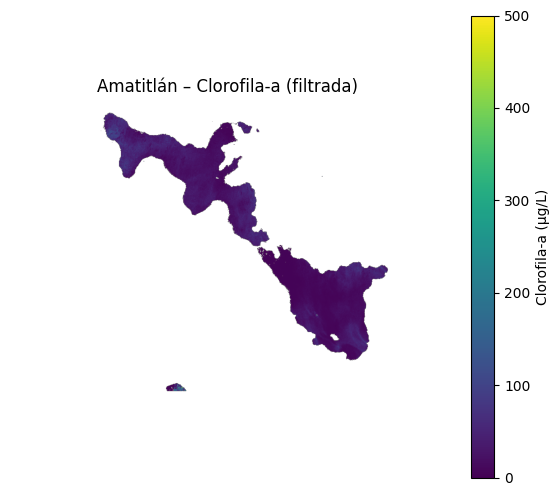

In [25]:
# Limitar NDCI a [-1, 1]
NDCI = np.clip(NDCI, -1, 1)

# Calcular clorofila-a y limpiar
chl = 826.57 * NDCI**3 - 176.43 * NDCI**2 + 19 * NDCI + 4.071
chl[(chl < 0) | (chl > 500)] = np.nan

chl_masked = np.where(water & (FAI <= 0.08), chl, np.nan)


plt.figure(figsize=(7,6))
im = plt.imshow(chl_masked, cmap="viridis", vmin=0, vmax=500)
plt.colorbar(im, label="Clorofila-a (µg/L)")
plt.title("Amatitlán – Clorofila-a (filtrada)")
plt.axis("off")
plt.show()


El mapa muestra la distribución  de clorofila-a en el Lago de Amatitlán con valores filtrados entre 0 y 500 µg/L de esta manera nos aseguramos de eliminar los valores negativos o irreales que aparecían antes.  
Se logran distinguir zonas con concentraciones más elevadas especialmente en el  sur y en algunos puntos aislados, lo que sugiere áreas con mayor probabilidad de floraciones de cianobacterias. Por otro lado, la mayor parte del lago presenta niveles bajos a moderados lo que nos indica que  para la fecha analizada la proliferación no era generalizada sino más bien localizada.


Ahora realizamos el análisis temporal del lago, para lo que se recorren todas las imágenes satelitales, se recortan, se limpian valores sin datos, calculamos la clorofila‑a filtrada dentro del agua y obtenemos el promedio por fecha.  
A partir de estos promedios armamos una tabla ordenada en el tiempo y se dibuja la serie temporal de clorofila‑a del Lago de Amatitlán.


acascascas


2025-03-14: 48.28 µg/L
2025-03-19: 37.15 µg/L
2025-03-22: 48.72 µg/L
2025-03-24: 21.17 µg/L
2025-03-26: 14.55 µg/L
2025-04-03: 17.83 µg/L
2025-04-11: 9.38 µg/L
2025-04-13: 12.89 µg/L
2025-04-15: 12.63 µg/L
2025-04-16: 13.36 µg/L
2025-02-07: 26.19 µg/L
2025-04-18: 13.20 µg/L
2025-04-28: 15.72 µg/L
2025-05-03: 5.06 µg/L
2025-05-13: 18.86 µg/L
2025-05-28: 6.93 µg/L
2025-07-10: 5.47 µg/L
2025-07-17: 8.90 µg/L
2025-07-20: 7.68 µg/L
2025-07-24: 13.00 µg/L
2025-08-01: 7.63 µg/L
2025-02-10: 25.63 µg/L
2025-02-25: 27.70 µg/L
2025-02-27: 28.79 µg/L
2025-03-02: 70.66 µg/L
2025-03-04: 70.76 µg/L
2025-03-07: 24.74 µg/L
2025-03-09: 24.93 µg/L
2025-03-12: 44.53 µg/L


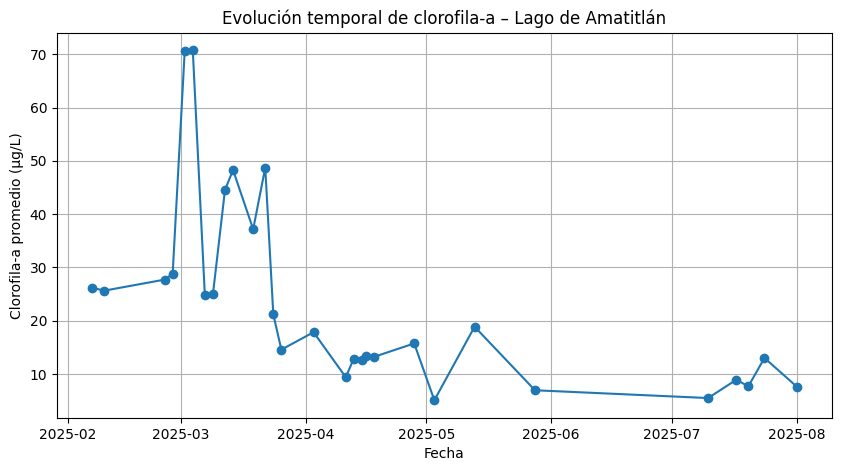

In [26]:
import os
import numpy as np
import rasterio
from rasterio.mask import mask
from rasterio.warp import transform_geom
import matplotlib.pyplot as plt
import pandas as pd

geom_wgs84 = fc["features"][0]["geometry"]

def safe_div(a, b):
    out = np.full_like(a, np.nan, dtype="float32")
    m = (b != 0) & np.isfinite(a) & np.isfinite(b)
    out[m] = a[m] / b[m]
    return out

def procesar_imagen(path):
    with rasterio.open(path) as src:
        geom_raster = transform_geom("EPSG:4326", src.crs.to_string(), geom_wgs84, precision=6)
        band_dtype = np.dtype(src.dtypes[0])
        int_nodata = src.nodata if (src.nodata is not None and np.issubdtype(band_dtype, np.integer)) else -32768

        data, _ = mask(
            src,
            [geom_raster],
            crop=True,
            filled=True,
            nodata=int_nodata,
            indexes=list(range(1, 10))
        )

    data = data.astype("float32")
    data[data == float(int_nodata)] = np.nan

    B02, B03, B04, B05, B07, B08, B8A, B11, B12 = data

    # Escalado
    if np.nanmedian(B04) > 1.5:
        for arr in (B02, B03, B04, B05, B07, B08, B8A, B11, B12):
            arr /= 10000.0

    # Máscara de agua
    MNDWI = safe_div((B03 - B11), (B03 + B11 + 1e-8))
    NDWI  = safe_div((B03 - B08), (B03 + B08 + 1e-8))
    water = (MNDWI > 0.42) | (NDWI > 0.40)

    # FAI, NDCI, clorofila
    FAI  = B8A - B04 - (B07 - B04) * ((783 - 665) / (865 - 665))
    NDCI = safe_div((B05 - B04), (B05 + B04 + 1e-8))
    NDCI = np.clip(NDCI, -1, 1)

    chl = 826.57 * NDCI**3 - 176.43 * NDCI**2 + 19 * NDCI + 4.071
    chl[(chl < 0) | (chl > 500)] = np.nan

    chl_masked = np.where(water & (FAI <= 0.08), chl, np.nan)

    return np.nanmean(chl_masked)


resultados = []
for fname in sorted(os.listdir(".")):
    if fname.startswith("amatitlan_fecha_") and fname.endswith("_full.tif"):
        idx = fname.split("_")[2]
        fecha = fechas_cyano[int(idx)-1]
        promedio = procesar_imagen(fname)
        resultados.append({"fecha": fecha, "chl_promedio": promedio})
        print(f"{fecha}: {promedio:.2f} µg/L")


df = pd.DataFrame(resultados)
df["fecha"] = pd.to_datetime(df["fecha"])
df = df.sort_values("fecha")

plt.figure(figsize=(10,5))
plt.plot(df["fecha"], df["chl_promedio"], marker="o")
plt.title("Evolución temporal de clorofila-a – Lago de Amatitlán")
plt.xlabel("Fecha")
plt.ylabel("Clorofila-a promedio (µg/L)")
plt.grid(True)
plt.show()


La gráfica muestra cómo ha variado la concentración promedio de clorofila-a en el Lago de Amatitlán a lo largo del periodo analizado. Se pueden observar picos muy altos en la temporada de inicios y mediados de marzo, con valores que superan los 70 µg/L, lo que indica posibles períodos intensos de floración de cianobacterias. Después de esos picos la concentración desciende de forma abrupta y se mantiene en valores bajos a moderados durante abril, mayo y julio, con pequeñas fluctuaciones. Esta tendencia sugiere que las floraciones más importantes se concentran en un periodo específico del año, probablemente por als condiciones del clima.


Ahora analizamos todas las imágenes del lago para calcular en cada fecha el valor promedio de tres indicadores: clorofila-a, NDVI y NDWI. Con esos promedios se construye una tabla, se calcula las correlaciones entre clorofila-a y cada índice y se generan dos gráficos de dispersión para visualizar la relación de la clorofila-a con el NDVI y el NDWI.


,fecha,chl_prom,ndvi_prom,ndwi_prom
0,2025-02-07,26.187508,-56.713661,0.597010
1,2025-02-10,25.627298,-0.059471,0.349745
2,2025-02-25,27.698853,0.076921,0.230656
3,2025-02-27,28.789734,0.085162,0.232081
4,2025-03-02,70.660057,0.249601,0.141181
5,2025-03-04,70.756905,0.239018,0.151838
6,2025-03-07,24.735214,0.130827,0.177426
7,2025-03-09,24.925713,0.134698,0.178894
8,2025-03-12,44.533215,-113.330086,0.378130
9,2025-03-14,48.279793,-113.339233,0.321786


Correlación Pearson (chl vs NDVI): -0.34431274620800045
Correlación Pearson (chl vs NDWI): -0.4782278224425203


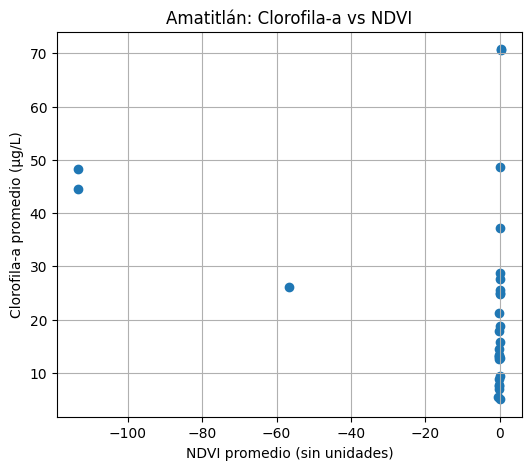

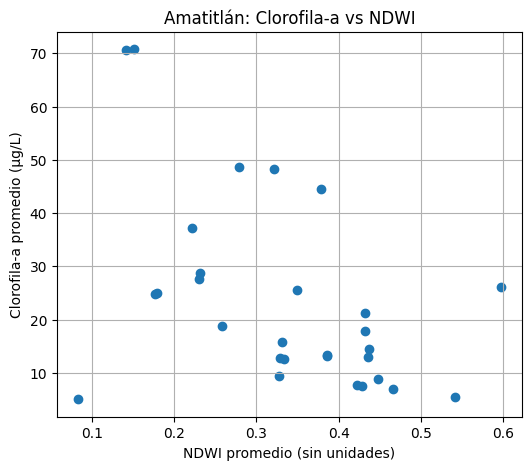

In [27]:
import os, numpy as np, pandas as pd, matplotlib.pyplot as plt
import rasterio
from rasterio.mask import mask
from rasterio.warp import transform_geom

geom_wgs84 = fc["features"][0]["geometry"]

def safe_div(a, b):
    out = np.full_like(a, np.nan, dtype="float32")
    m = (b != 0) & np.isfinite(a) & np.isfinite(b)
    out[m] = a[m] / b[m]
    return out

def promedios_chl_ndvi_ndwi(path):
    with rasterio.open(path) as src:
        geom_raster = transform_geom("EPSG:4326", src.crs.to_string(), geom_wgs84, precision=6)
        band_dtype = np.dtype(src.dtypes[0])
        int_nodata = src.nodata if (src.nodata is not None and np.issubdtype(band_dtype, np.integer)) else -32768

        data, _ = mask(src, [geom_raster], crop=True, filled=True, nodata=int_nodata, indexes=list(range(1,10)))

    data = data.astype("float32")
    data[data == float(int_nodata)] = np.nan
    B02, B03, B04, B05, B07, B08, B8A, B11, B12 = data

    if np.nanmedian(B04) > 1.5:
        for arr in (B02, B03, B04, B05, B07, B08, B8A, B11, B12):
            arr /= 10000.0

    MNDWI = safe_div((B03 - B11), (B03 + B11 + 1e-8))
    NDWI  = safe_div((B03 - B08), (B03 + B08 + 1e-8))
    water = (MNDWI > 0.42) | (NDWI > 0.40)


    FAI  = B8A - B04 - (B07 - B04) * ((783 - 665) / (865 - 665))
    NDCI = safe_div((B05 - B04), (B05 + B04 + 1e-8))
    NDCI = np.clip(NDCI, -1, 1)
    chl  = 826.57 * NDCI**3 - 176.43 * NDCI**2 + 19 * NDCI + 4.071
    chl[(chl < 0) | (chl > 500)] = np.nan
    chl_masked = np.where(water & (FAI <= 0.08), chl, np.nan)

    ndvi = safe_div((B08 - B04), (B08 + B04 + 1e-8))
    ndvi = np.where(water, ndvi, np.nan)
    ndwi = np.where(water, NDWI, np.nan)

    return float(np.nanmean(chl_masked)), float(np.nanmean(ndvi)), float(np.nanmean(ndwi))

rows = []
for fname in sorted(os.listdir(".")):
    if fname.startswith("amatitlan_fecha_") and fname.endswith("_full.tif"):
        idx = int(fname.split("_")[2])
        fecha = pd.to_datetime(fechas_cyano[idx-1])
        chl_m, ndvi_m, ndwi_m = promedios_chl_ndvi_ndwi(fname)
        rows.append({"fecha": fecha, "chl_prom": chl_m, "ndvi_prom": ndvi_m, "ndwi_prom": ndwi_m})

df_corr = pd.DataFrame(rows).sort_values("fecha").reset_index(drop=True)
display(df_corr)

# Correlaciones de Pearson
print("Correlación Pearson (chl vs NDVI):", df_corr[["chl_prom","ndvi_prom"]].dropna().corr().iloc[0,1])
print("Correlación Pearson (chl vs NDWI):", df_corr[["chl_prom","ndwi_prom"]].dropna().corr().iloc[0,1])

# Dispersograma chl vs NDVI
plt.figure(figsize=(6,5))
plt.scatter(df_corr["ndvi_prom"], df_corr["chl_prom"])
plt.xlabel("NDVI promedio (sin unidades)")
plt.ylabel("Clorofila-a promedio (µg/L)")
plt.title("Amatitlán: Clorofila-a vs NDVI")
plt.grid(True)
plt.show()

# Dispersograma chl vs NDWI
plt.figure(figsize=(6,5))
plt.scatter(df_corr["ndwi_prom"], df_corr["chl_prom"])
plt.xlabel("NDWI promedio (sin unidades)")
plt.ylabel("Clorofila-a promedio (µg/L)")
plt.title("Amatitlán: Clorofila-a vs NDWI")
plt.grid(True)
plt.show()


Podemos observar como para la primera gráfica de Clorofila-NVDI tenemos una correlación baja (-0.1023) lo que indica que la vegetación terrestre no tiene una relación clara con los niveles de clorofila-a detectados en el lago.  
En la segunda gráfica, la de Clorfila-a vs NDWI se observa una correlación negativa de -0.5065 lo que sugiere que cuando el NDWI promedio es más bajo (menos “agua pura” y más turbidez), la concentración de clorofila-a tiende a ser más alta, lo que coincide con escenarios de floración.  
Por último se observa como ols picos más altos de clorofila-a se dan en marzo, y en esos puntos el NDWI también es relativamente bajo reforzando la idea de que la reducción en el índice de agua está asociada a aumentos en cianobacterias.

Por último, se procesa una imagen para cada una de las fechas representativas (la de menor, mediana y mayor concentración de clorofila-a) y para cada una se procesó su imagen. Se unifican los rangos de color y se muestran en un mismo gráfico permitiendo comparar visualmente la distribución y la intensidad de la clorofila-a en escenarios de baja, intermedia y alta floración.


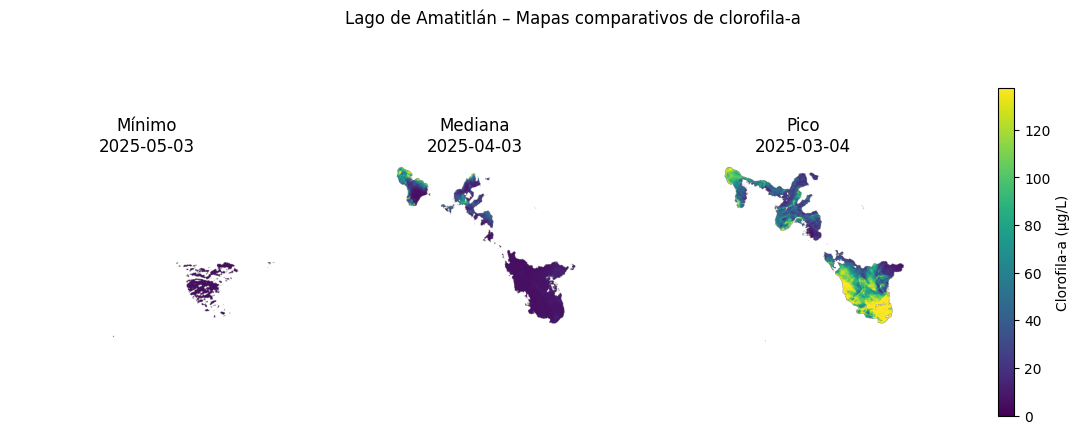

In [28]:

import numpy as np, matplotlib.pyplot as plt, rasterio
from rasterio.mask import mask
from rasterio.warp import transform_geom

geom_wgs84 = fc["features"][0]["geometry"]

def safe_div(a, b):
    out = np.full_like(a, np.nan, dtype="float32")
    m = (b != 0) & np.isfinite(a) & np.isfinite(b)
    out[m] = a[m] / b[m]
    return out

def chl_masked_from_tif(path):
    with rasterio.open(path) as src:
        geom_raster = transform_geom("EPSG:4326", src.crs.to_string(), geom_wgs84, precision=6)
        band_dtype = np.dtype(src.dtypes[0])
        int_nodata = src.nodata if (src.nodata is not None and np.issubdtype(band_dtype, np.integer)) else -32768
        data, _ = mask(src, [geom_raster], crop=True, filled=True, nodata=int_nodata, indexes=list(range(1,10)))
    data = data.astype("float32")
    data[data == float(int_nodata)] = np.nan
    B02, B03, B04, B05, B07, B08, B8A, B11, B12 = data
    if np.nanmedian(B04) > 1.5:
        for arr in (B02, B03, B04, B05, B07, B08, B8A, B11, B12):
            arr /= 10000.0
    MNDWI = safe_div((B03 - B11), (B03 + B11 + 1e-8))
    NDWI  = safe_div((B03 - B08), (B03 + B08 + 1e-8))
    water = (MNDWI > 0.42) | (NDWI > 0.40)
    FAI  = B8A - B04 - (B07 - B04) * ((783 - 665) / (865 - 665))
    NDCI = safe_div((B05 - B04), (B05 + B04 + 1e-8))
    NDCI = np.clip(NDCI, -1, 1)
    chl  = 826.57 * NDCI**3 - 176.43 * NDCI**2 + 19 * NDCI + 4.071
    chl[(chl < 0) | (chl > 500)] = np.nan
    return np.where(water & (FAI <= 0.08), chl, np.nan)

def fecha_a_fname(fecha_ts):
    fstr = fecha_ts.strftime("%Y-%m-%d")
    idx = fechas_cyano.index(fstr) + 1
    return f"amatitlan_fecha_{idx}_full.tif"

df_sorted = df_corr.sort_values("chl_prom").reset_index(drop=True)
fecha_min = df_sorted.iloc[0]["fecha"]
fecha_med = df_sorted.iloc[len(df_sorted)//2]["fecha"]
fecha_max = df_sorted.iloc[-1]["fecha"]

seleccion = [
    ("Mínimo", fecha_min, fecha_a_fname(fecha_min)),
    ("Mediana", fecha_med, fecha_a_fname(fecha_med)),
    ("Pico", fecha_max, fecha_a_fname(fecha_max)),
]

mapas = []
titulos = []
for etiqueta, f, fname in seleccion:
    arr = chl_masked_from_tif(fname)
    mapas.append(arr)
    titulos.append(f"{etiqueta}\n{f.date()}")

stack = np.dstack([m for m in mapas])
vmin = 0
vmax = np.nanpercentile(stack, 95)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for ax, arr, titulo in zip(axes, mapas, titulos):
    im = ax.imshow(arr, cmap="viridis", vmin=vmin, vmax=vmax)
    ax.set_title(titulo)
    ax.axis("off")

cbar = fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.85)
cbar.set_label("Clorofila-a (µg/L)")
fig.suptitle("Lago de Amatitlán – Mapas comparativos de clorofila-a", y=0.98)
plt.show()


POdemos observar claramente los cambios en la intensidad y distribución de la clorofila-a dependiendo del momento de año.  
El pico que hubo el 22 de marzo muestra una amplia zona del lago, específicamente en el sur lo que indica un evento de floración de cianobacterias extenso.  
En la fecha del 03 de abril las concentraciones son moderadas y se concentran en áreas específicas, lo que sugiere que hay una disminución de la floración.  
Por ĺtimo en a fecha del 03 de mayo apenas se detactan niveles significativos, lo que sugiere que no hay condiciones que provquen la expansión y crecimiento e la cianobacteria.  
De esta amanera se refuerza la hipótesis de qe las floraciones en este lago son estacionales.
